## Project 2


Regression Discontinuity Design (RDD)  is
a key method used to determine a certain effect of an intervention based on comparing de before and after a specific threshold. For this project we used the open source database from the National Institute of health of Quebec. This specific csv files has the number of cases per day as well as deaths, accumulated cases, accumulated deaths, etc; For now we are only going to focus on the dates and the number of cases. 

The data was taken from: https://msss.gouv.qc.ca.

This project is by  by Alejandra Zambrano, Agata Miler and Zeinab Masoomikhangha 


This page will cover when to use RDD, sharp vs.fuzzy design, how to interpret results, 
and methods of treatment effect estimation

We start by installing the rdd library, this library is based on some methods od statsmodels focused on RDD

In [3]:
!pip install rdd

In [1]:
#all necessary imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from rdd import rdd

In [2]:
data= pd.read_csv("COVID19_Qc_RapportINSPQ_HistoVigie.csv")#loading covid19 cases in Quebec
data= data.drop(0) # drop first line


To take a first glance of the data it's necesarry to first trim it only focused on the year 2020 and some of 2021 and then plot it

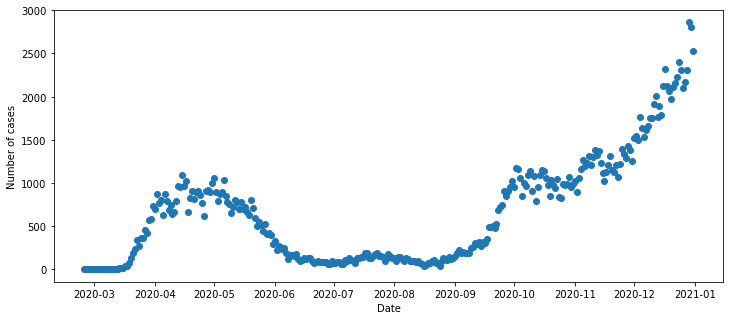

In [3]:

data.Date= pd.to_datetime(data.Date)#convert to dtaetime
data.Nb_Nvx_Cas= pd.to_numeric(data.Nb_Nvx_Cas)#convert to numeric data
data= data.loc[(data.Date>'2020-02-24') & (data.Date<'2021-01-01') ]

cases= data[['Date','Nb_Nvx_Cas']]

fig, ax = plt.subplots( figsize=(12, 5))
plt.scatter(cases.Date,cases.Nb_Nvx_Cas)
plt.xlabel("Date")
plt.ylabel("Number of cases")
plt.show() 

## 1. Effect of the 20/3/2020 lockdown

In the next cells we are going to see the effect of the first lockdown when covid started in the province of Quebec

In [4]:
cases.insert(0, 'New_ID', range(0, len(cases)))

In [5]:
cases_lockdown= cases.copy()
# We want to create a binary column to know if  specific date was during lockdown or not
lockdown=(cases.Date>'2020-03-20').astype(int)
cases_lockdown['lockdown']=lockdown
cases_lockdown

,New_ID,Date,Nb_Nvx_Cas,lockdown
34,0,2020-02-25,1,0
35,1,2020-02-26,0,0
36,2,2020-02-27,0,0
37,3,2020-02-28,1,0
38,4,2020-02-29,0,0
...,...,...,...,...
340,306,2020-12-27,2164,1
341,307,2020-12-28,2310,1
342,308,2020-12-29,2860,1
343,309,2020-12-30,2811,1


As we can see the date range is pretty big, that's why we need to choose a smaller sample closer to the threshold date ('2020-03-20') to make a more accurate regression. For this we used the rdd library that has a method named ``` optimal_bandwidth ```, this method chooses the size of the range of data needed to do rdd.

In [7]:
threshold

24

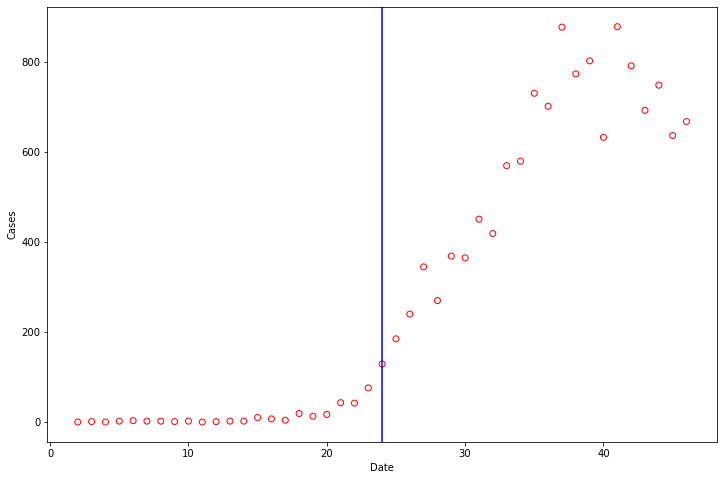

In [8]:
threshold= cases.loc[cases.Date=='2020-03-20']['New_ID'].values[0]#starting lockdown called cut_off point

#finding optimal bandwidth around cut-off point
lockdown_sample = rdd.optimal_bandwidth(cases_lockdown['Nb_Nvx_Cas'], cases_lockdown['New_ID'], cut=threshold)
selected_data = rdd.truncated_data(cases_lockdown, 'New_ID', lockdown_sample, cut=threshold)

#We can plot to take a better look at the data chosen
plt.figure(figsize=(12, 8))
plt.scatter(selected_data['New_ID'], selected_data['Nb_Nvx_Cas'], facecolors='none', edgecolors='r')
plt.xlabel('Date')
plt.ylabel('Cases')
plt.axvline(x=threshold, color='b')
plt.show()
plt.close()

To approach this we decided to go with Two Stage modelling, basically we take separate data between untreated (before threshold) and treated (after threshold). After we apply linear regression on both sides two analyse the difference in the data

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             Nb_Nvx_Cas   R-squared (uncentered):                   0.493
Model:                            OLS   Adj. R-squared (uncentered):              0.470
Method:                 Least Squares   F-statistic:                              21.43
Date:                Tue, 05 Jul 2022   Prob (F-statistic):                    0.000130
Time:                        10:40:05   Log-Likelihood:                         -106.12
No. Observations:                  23   AIC:                                      214.2
Df Residuals:                      22   BIC:                                      215.4
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
New_ID         1.6505      0.357      4.629      0.000       0.911       2.390
==============================================================================
Omnibus:                       36.367   Durbin-Watson:                   0.339
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               94.692
Skew:                           2.859   Prob(JB):                     2.74e-21
Kurtosis:                      11.131   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

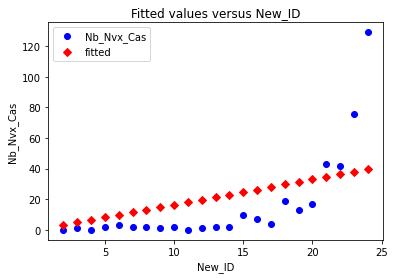

In [9]:
untreated= selected_data.loc[selected_data.lockdown==0]#infected cases before lockdown (cut-off point)
untreated=untreated.drop(['lockdown'],axis=1)
est1 = sm.OLS(untreated['Nb_Nvx_Cas'],untreated['New_ID'] ).fit() #regression before cut-off
sm.graphics.plot_fit(est1, 'New_ID', vlines=False);
est1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Nb_Nvx_Cas   R-squared:                       0.685
Model:                            OLS   Adj. R-squared:                  0.670
Method:                 Least Squares   F-statistic:                     43.55
Date:                Tue, 05 Jul 2022   Prob (F-statistic):           1.99e-06
Time:                        10:40:06   Log-Likelihood:                -136.02
No. Observations:                  22   AIC:                             276.0
Df Residuals:                      20   BIC:                             278.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -388.6674    148.926     -2.610      0.017    -699.321     -78.014
New_ID        27.2518      4.130      6.599      0.000      18.638      35.866
==============================================================================
Omnibus:                        0.573   Durbin-Watson:                   0.794
Prob(Omnibus):                  0.751   Jarque-Bera (JB):                0.652
Skew:                           0.299   Prob(JB):                        0.722
Kurtosis:                       2.406   Cond. No.                         205.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

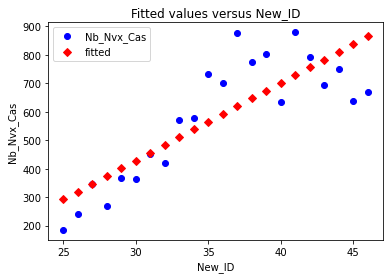

In [10]:
treated= selected_data.loc[selected_data.lockdown==1]#infected cases after lockdown(cut-off point)
treated=treated.drop(['lockdown'],axis=1)
est2 = sm.OLS(treated['Nb_Nvx_Cas'],sm.add_constant(treated['New_ID']) ).fit()#regression after cut-off
sm.graphics.plot_fit(est2, 'New_ID', vlines=False);
est2.summary()


With the models trained we can plot both models on the same figure to make a better comparison between the data.

Intercet of x_untreated with threshold 39.61298224127373
Intercet of x_treated with threshold 277.6121411862319


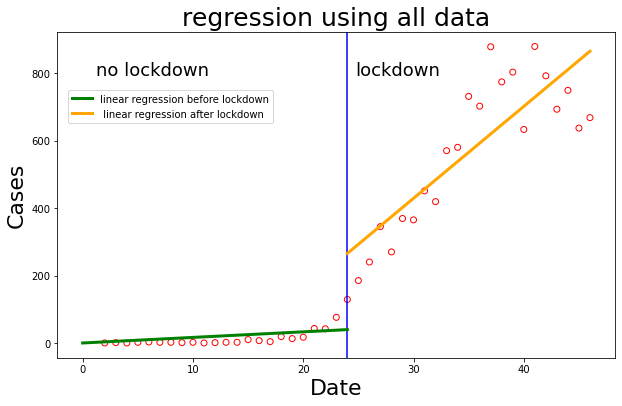

In [11]:
fig, ax = plt.subplots(figsize=(10, 6))

#scttered plot for infected cases 
plt.scatter(selected_data['New_ID'], selected_data['Nb_Nvx_Cas'], facecolors='none', edgecolors='r')
plt.axvline(x=threshold, color='b')#plotting at cut-off point


#predictions'plots
x_untreated = np.linspace(0, threshold)
ypred_untreated = est1.predict(x_untreated)
print('Intercet of x_untreated with threshold', ypred_untreated[-1])
plt.plot(x_untreated, ypred_untreated, 'green', linewidth=3.0, label= 'linear regression before lockdown' )


x_treated = np.linspace(threshold, 46)
ypred_treated = est2.predict(sm.add_constant(x_treated))
print('Intercet of x_treated with threshold',ypred_treated[1])
plt.plot(x_treated, ypred_treated, 'orange', linewidth=3.0, label=' linear regression after lockdown')


#label of axes
ax.set_xlabel("Date", fontsize=22)
ax.set_ylabel("Cases", fontsize=22)
ax.set_title("regression using all data", fontsize=25)

# annotate subject status of each side
plt.text(
    0.17,
    0.88,
    "no lockdown",
    horizontalalignment="center",
    verticalalignment="center",
    transform=ax.transAxes,
    fontsize=18,
)

plt.text(
    0.61,
    0.88,
    "lockdown",
    horizontalalignment="center",
    verticalalignment="center",
    transform=ax.transAxes,
    fontsize=18,
)
plt.legend(loc=(0.02,0.72))
plt.show()


After the regression on both treated and untreaded sides we can see that the p value of the date variable is really close to zero which means a big correlation between the date and the number of cases. The cutoff value in this case is the difference between the intercepts in the threshold, as we can see the difference is about 238 units, which means there is a significant increase in cases before and after lockdown. There is also a difference in the slopes of the lines, it's easy to see that the slope is more pronunciated of the right side, which means cases are increasing more rapidly after the day of lockdown. 

This makes a lot of sense since this is basically when Covid started hitting Quebec, people where already infected before the lockdown so you can see all this cases going up in a really fast way.

## 2. Effect of the reopening of schools on 31/8/2020

We are going to take the same approach to analyse this event 

In [12]:
cases_school= cases.copy()
schools=(cases.Date>'2020-08-31').astype(int)
cases_school['school']=schools


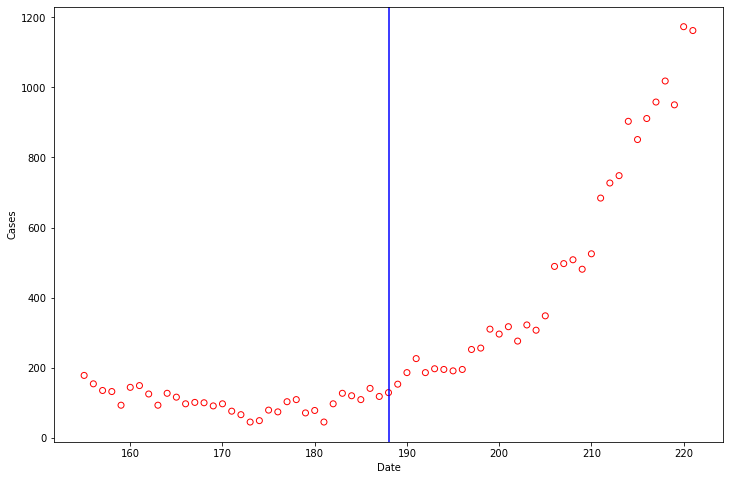

In [13]:
#Choose the optimal bandwidth
threshold= cases.loc[cases.Date=='2020-08-31']['New_ID'].values[0]#defining cut_off point

school_sample = rdd.optimal_bandwidth(cases_school['Nb_Nvx_Cas'], cases_school['New_ID'], cut=threshold)
selected_data = rdd.truncated_data(cases_school, 'New_ID', school_sample, cut=threshold)

plt.figure(figsize=(12, 8))
plt.scatter(selected_data['New_ID'], selected_data['Nb_Nvx_Cas'], facecolors='none', edgecolors='r')
plt.xlabel('Date')
plt.ylabel('Cases')
plt.axvline(x=threshold, color='b')
plt.show()
plt.close()

In [30]:
threshold

304

Since this plot doesn't look that linear we decided to use higher polynomial values.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Nb_Nvx_Cas   R-squared:                       0.645
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     18.18
Date:                Tue, 05 Jul 2022   Prob (F-statistic):           6.51e-07
Time:                        10:40:09   Log-Likelihood:                -147.83
No. Observations:                  34   AIC:                             303.7
Df Residuals:                      30   BIC:                             309.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.118e+04   2.32e+04     -0.912      0.369   -6.86e+04    2.63e+04
x1           420.6061    407.703      1.032      0.310    -412.034    1253.246
x2            -2.7238      2.381     -1.144      0.262      -7.586       2.139
x3             0.0058      0.005      1.253      0.220      -0.004       0.015
==============================================================================
Omnibus:                        1.943   Durbin-Watson:                   1.553
Prob(Omnibus):                  0.378   Jarque-Bera (JB):                1.597
Skew:                          -0.521   Prob(JB):                        0.450
Kurtosis:                       2.796   Cond. No.                     3.51e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.51e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

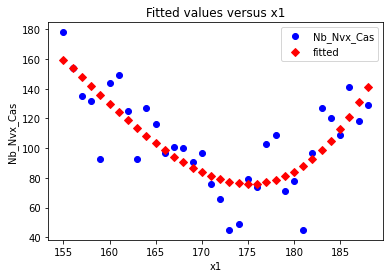

In [14]:
from sklearn.preprocessing import PolynomialFeatures
#linear regression on data before reopening schools in Quebec as cutoff point
untreated= selected_data.loc[selected_data.school==0]#infected unvaccinated cases before reopening schools(cut-off point)
untreated=untreated.drop(['school'],axis=1)
untreated=untreated.drop(['Date'],axis=1)

poly = PolynomialFeatures(3)#make it third degree polynomial in order to fit better
X1=poly.fit_transform(untreated.drop(['Nb_Nvx_Cas'],axis=1))

est1 = sm.OLS(untreated['Nb_Nvx_Cas'],X1 ).fit()
sm.graphics.plot_fit(est1, 'x1', vlines=False);
est1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Nb_Nvx_Cas   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     464.4
Date:                Tue, 05 Jul 2022   Prob (F-statistic):           1.34e-24
Time:                        10:40:09   Log-Likelihood:                -172.62
No. Observations:                  33   AIC:                             353.2
Df Residuals:                      29   BIC:                             359.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.114e+05   1.07e+05      1.042      0.306   -1.07e+05     3.3e+05
x1         -1463.3300   1568.075     -0.933      0.358   -4670.404    1743.744
x2             6.1943      7.657      0.809      0.425      -9.466      21.854
x3            -0.0083      0.012     -0.665      0.511      -0.034       0.017
==============================================================================
Omnibus:                        1.857   Durbin-Watson:                   1.745
Prob(Omnibus):                  0.395   Jarque-Bera (JB):                0.847
Skew:                          -0.313   Prob(JB):                        0.655
Kurtosis:                       3.472   Cond. No.                     1.11e+11
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.11e+11. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

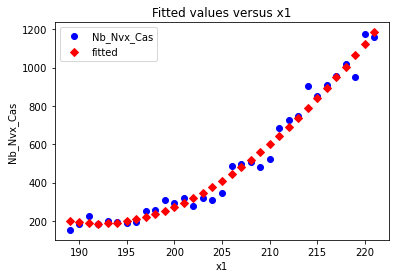

In [15]:
treated= selected_data.loc[selected_data.school==1]#infected unvaccinated cases after reopening schools(cut-off point)
treated=treated.drop(['school'],axis=1)
treated=treated.drop(['Date'],axis=1)
poly = PolynomialFeatures(3)
X=poly.fit_transform(treated.drop(['Nb_Nvx_Cas'],axis=1))#infected unvaccinated cases after reopening schools
est2 = sm.OLS(treated['Nb_Nvx_Cas'],X ).fit()#regression on 
sm.graphics.plot_fit(est2, 'x1', vlines=False);
est2.summary()

Intercet of x_untreated with threshold 141.34998804809584
Intercet of x_treated with threshold 199.03148527041776


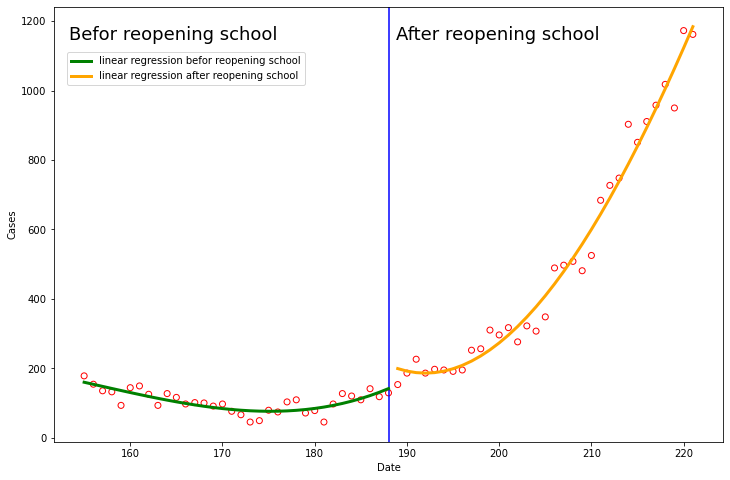

In [16]:
plt.figure(figsize=(12, 8))
plt.scatter(selected_data['New_ID'], selected_data['Nb_Nvx_Cas'], facecolors='none', edgecolors='r')
plt.axvline(x=threshold, color='b')

#predicted plot before reopening schools
ypred_closed = est1.predict(X1)
print('Intercet of x_untreated with threshold', ypred_closed[-1])
plt.plot(X1[:,1], ypred_closed, 'green', linewidth=3.0, label= 'linear regression befor reopening school' )


#predicted plot after reopening schools
ypred_reopen = est2.predict(X)
print('Intercet of x_treated with threshold', ypred_reopen[0])
plt.plot(X[:,1], ypred_reopen, 'orange', linewidth=3.0, label= 'linear regression after reopening school' )


#label of axes
plt.xlabel('Date')
plt.ylabel('Cases')

# annotate subject status of each side
plt.text(
    0.15,
    1.2,
    "Befor reopening school",
    horizontalalignment="center",
    verticalalignment="center",
    transform=ax.transAxes,
    fontsize=18,
)

plt.text(
    0.73,
    1.2,
    "After reopening school",
    horizontalalignment="center",
    verticalalignment="center",
    transform=ax.transAxes,
    fontsize=18,
)
plt.legend(loc=(0.02,0.82))
plt.show()
plt.close()


Here the effect of the reopening is different from the lockdown because it has a slow increase and it skyrockets after the day 205 (aprox). This is something that was probably expected by the schools and the health deparments

## 2. Effect of the 25/12/2020 lockdown

In [17]:
data= pd.read_csv("COVID19_Qc_RapportINSPQ_HistoVigie.csv") #loading data for extending data range
data= data.drop(0)

data.Date= pd.to_datetime(data.Date)
data.Nb_Nvx_Cas= pd.to_numeric(data.Nb_Nvx_Cas)#converting to numeris data
data= data.loc[(data.Date>'2020-02-24') & (data.Date<'2021-04-01') ]

cases= data[['Date','Nb_Nvx_Cas']]#limitted data
cases.insert(0, 'New_ID', range(0, len(cases)))#adding column for having new ID

In [18]:
cases_lockdown2= cases.copy()
lockdown2=(cases.Date>'2020-12-25').astype(int)#making binary as lockdown column
cases_lockdown2['lockdown']=lockdown2#added to dataframe
cases_lockdown2

,New_ID,Date,Nb_Nvx_Cas,lockdown
34,0,2020-02-25,1,0
35,1,2020-02-26,0,0
36,2,2020-02-27,0,0
37,3,2020-02-28,1,0
38,4,2020-02-29,0,0
...,...,...,...,...
430,396,2021-03-27,932,1
431,397,2021-03-28,831,1
432,398,2021-03-29,942,1
433,399,2021-03-30,1001,1


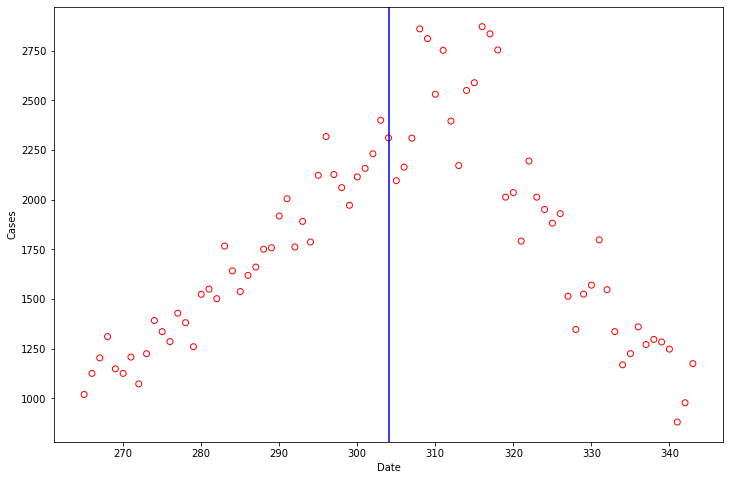

In [19]:
threshold= cases.loc[cases.Date=='2020-12-25']['New_ID'].values[0]#starting lockdown called cut_off point
#finding optimal bandwidth around cut-off point
lockdown_sample = rdd.optimal_bandwidth(cases_lockdown2['Nb_Nvx_Cas'], cases_lockdown2['New_ID'], cut=threshold)
selected_data = rdd.truncated_data(cases_lockdown2, 'New_ID', lockdown_sample, cut=threshold)
#plotting around cutoff in banwidth's range
plt.figure(figsize=(12, 8))
plt.scatter(selected_data['New_ID'], selected_data['Nb_Nvx_Cas'], facecolors='none', edgecolors='r')
plt.xlabel('Date')
plt.ylabel('Cases')
plt.axvline(x=threshold, color='b')
plt.show()
plt.close()

In [21]:
threshold

304

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Nb_Nvx_Cas   R-squared:                       0.926
Model:                            OLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                     477.9
Date:                Tue, 05 Jul 2022   Prob (F-statistic):           4.00e-23
Time:                        10:40:52   Log-Likelihood:                -243.47
No. Observations:                  40   AIC:                             490.9
Df Residuals:                      38   BIC:                             494.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -7655.6874    426.033    -17.970      0.000   -8518.146   -6793.229
New_ID        32.7104      1.496     21.862      0.000      29.681      35.739
==============================================================================
Omnibus:                        1.776   Durbin-Watson:                   1.546
Prob(Omnibus):                  0.412   Jarque-Bera (JB):                1.121
Skew:                           0.404   Prob(JB):                        0.571
Kurtosis:                       3.137   Cond. No.                     7.02e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.02e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

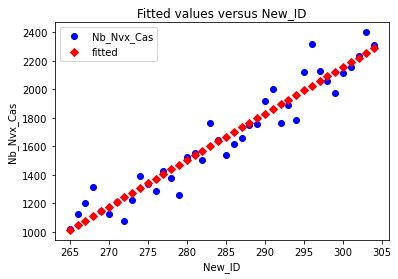

In [26]:
#linear regression on data before lockdown as cutoff point
untreated2= selected_data.loc[selected_data.lockdown==0]
untreated2=untreated2.drop(['lockdown'],axis=1)
est3 = sm.OLS(untreated2['Nb_Nvx_Cas'],sm.add_constant(untreated2['New_ID'] )).fit()
sm.graphics.plot_fit(est3, 'New_ID', vlines=False);
est3.summary()

In [27]:
treated2

,New_ID,Date,Nb_Nvx_Cas
339,305,2020-12-26,2096
340,306,2020-12-27,2164
341,307,2020-12-28,2310
342,308,2020-12-29,2860
343,309,2020-12-30,2811
344,310,2020-12-31,2531
345,311,2021-01-01,2752
346,312,2021-01-02,2396
347,313,2021-01-03,2172
348,314,2021-01-04,2550


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Nb_Nvx_Cas   R-squared:                       0.780
Model:                            OLS   Adj. R-squared:                  0.774
Method:                 Least Squares   F-statistic:                     131.5
Date:                Tue, 05 Jul 2022   Prob (F-statistic):           9.71e-14
Time:                        10:40:54   Log-Likelihood:                -274.47
No. Observations:                  39   AIC:                             552.9
Df Residuals:                      37   BIC:                             556.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.685e+04   1304.731     12.913      0.000    1.42e+04    1.95e+04
New_ID       -46.1433      4.025    -11.466      0.000     -54.298     -37.989
==============================================================================
Omnibus:                        1.194   Durbin-Watson:                   0.782
Prob(Omnibus):                  0.550   Jarque-Bera (JB):                0.393
Skew:                           0.070   Prob(JB):                        0.822
Kurtosis:                       3.471   Cond. No.                     9.34e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.34e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

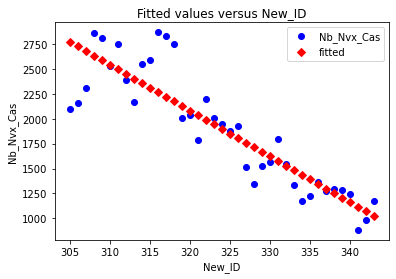

In [28]:
#linear regression on data after lockdown as cutoff point
treated2= selected_data.loc[selected_data.lockdown==1]
treated2=treated2.drop(['lockdown'],axis=1)
est4 = sm.OLS(treated2['Nb_Nvx_Cas'],sm.add_constant(treated2['New_ID']) ).fit()
sm.graphics.plot_fit(est4, 'New_ID', vlines=False);
est4.summary()

Intercet of x_untreated with threshold 2288.2780487804876
Intercet of x_untreated with threshold 2821.020242914985


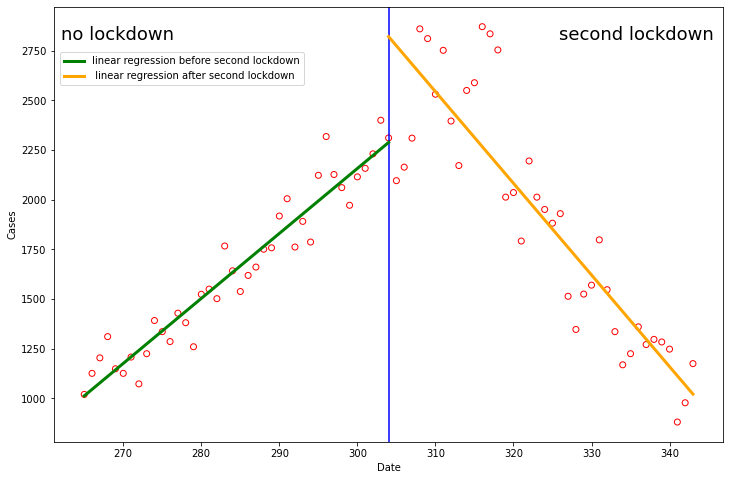

In [29]:
plt.figure(figsize=(12, 8))
plt.scatter(selected_data['New_ID'], selected_data['Nb_Nvx_Cas'], facecolors='none', edgecolors='r')
plt.axvline(x=threshold, color='b')

#predictions' plots

x_untreated = np.linspace(265, threshold)
ypred_untreated2 = est3.predict(sm.add_constant(x_untreated))
print('Intercet of x_untreated with threshold', ypred_untreated2[-1])
plt.plot(x_untreated, ypred_untreated2, 'green', linewidth=3.0, label= 'linear regression before second lockdown' )


x_treated = np.linspace(threshold, 343)
ypred_treated = est4.predict(sm.add_constant(x_treated))
print('Intercet of x_untreated with threshold', ypred_treated[0])
plt.plot(x_treated, ypred_treated, 'orange', linewidth=3.0, label=' linear regression after second lockdown')

# label for axes
ax.set_xlabel("Date", fontsize=22)
ax.set_ylabel("Cases", fontsize=22)
ax.set_title("regression using all data", fontsize=25)
plt.xlabel('Date')
plt.ylabel('Cases')

# annotate subject status of each side
plt.text(
    0.05,
    1.2,
    "no lockdown",
    horizontalalignment="center",
    verticalalignment="center",
    transform=ax.transAxes,
    fontsize=18,
)

plt.text(
    0.98,
    1.2,
    "second lockdown",
    horizontalalignment="center",
    verticalalignment="center",
    transform=ax.transAxes,
    fontsize=18,
)
plt.legend(loc=(0.01,0.82))
plt.show()


In this case we can actually see the postive effect of the second lockdown. The cases where going up rapidly hitting a high of almost 2821 and then rapidly going down with a slope of -46.1433	, this means cases where reduced by 46 each day.